In [1]:
import pybedtools as pbt
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np

In [2]:
files2 = glob.glob('/home/aram/data/martina_tdp/post_review_tdp_mutants/group1/*')
files1 = glob.glob('/home/aram/data/martina_tdp/post_review_tdp_mutants/group2/*')
files = files1 + files2
files = [f for f in files if 'mapped_to_genome_single' in f]
files

['/home/aram/data/martina_tdp/post_review_tdp_mutants/group2/tardbp-g294a-egfp-hek293-2-20201021-ju_mapped_to_genome_single.bed.gz',
 '/home/aram/data/martina_tdp/post_review_tdp_mutants/group2/tardbp-g294a-egfp-hek293-1-20201021-ju_mapped_to_genome_single.bed.gz',
 '/home/aram/data/martina_tdp/post_review_tdp_mutants/group2/tardbp-a326p-egfp-hek293-1-20201021-ju_mapped_to_genome_single.bed.gz',
 '/home/aram/data/martina_tdp/post_review_tdp_mutants/group2/tardbp-g335a-egfp-hek293-2-20201021-ju_mapped_to_genome_single.bed.gz',
 '/home/aram/data/martina_tdp/post_review_tdp_mutants/group2/tardbp-q331k-egfp-hek293-1-20201021-ju_mapped_to_genome_single.bed.gz',
 '/home/aram/data/martina_tdp/post_review_tdp_mutants/group2/tardbp-m337p-egfp-hek293-1-20201021-ju_mapped_to_genome_single.bed.gz',
 '/home/aram/data/martina_tdp/post_review_tdp_mutants/group2/tardbp-a326p-egfp-hek293-2-20201021-ju_mapped_to_genome_single.bed.gz',
 '/home/aram/data/martina_tdp/post_review_tdp_mutants/group2/tardbp-q

In [3]:
reference_bs = pbt.BedTool('/home/aram/Dropbox (The Francis Crick)/aram/martina_post_review/reference_binding_sites/tardbp_reference_binding_sites.bed')

In [4]:
reference_bs.head()

GL000194.1	75522	75545	.	22.0	-	3len30	dense	AA
 GL000194.1	81461	81479	.	13.0	-	3len30	medium	UA
 GL000194.1	92228	92285	.	68.0	-	2len30-60	dense	UG
 GL000194.1	99578	99599	.	23.0	-	3len30	sparse	UG
 GL000008.2	154464	154475	.	113.0	+	3len30	dense	AA
 GL000008.2	155093	155130	.	110.0	+	2len30-60	medium	UA
 KI270442.1	217328	217337	.	19.0	-	3len30	dense	AA
 KI270711.1	8179	8241	.	520.0	-	1len60-100	dense	UG
 KI270711.1	11269	11343	.	123.0	-	1len60-100	dense	UG
 KI270713.1	31706	31707	.	12.0	-	3len30	dense	UG
 

In [5]:
reference_bs.tail()

chrX	136838858	136838935	.	112.0	-	1len60-100	dense	AA
chrX	145299203	145299248	.	123.0	+	2len30-60	dense	UG
chrX	150765165	150765197	.	111.0	+	2len30-60	dense	AA
chrX	153051388	153051426	.	107.0	-	2len30-60	dense	AA
chrX	153473582	153473584	.	112.0	+	3len30	dense	UG
chrX	155398343	155398462	.	155.0	-	0len100plus	dense	UA
chrY	323501	323591	.	121.0	+	1len60-100	dense	UG
chrY	19751306	19751338	.	427.0	+	2len30-60	medium	UA
chrY	20590897	20590899	.	166.0	-	3len30	dense	UA
chrY	26389862	26389939	.	132.0	-	1len60-100	dense	UG



In [46]:
def merge_peaks(peaks, n):
    return peaks.sort().merge(d=n, s=True, c=[4, 5, 6, 7, 8, 9], o=['distinct', 'sum', 'distinct', 'distinct', 'distinct', 'distinct'])

In [48]:
df_out = pd.DataFrame()
for i, file in enumerate(files):
    temp_name = file.split('/')[-1].replace('-ju_mapped_to_genome_single', '').replace('.bed.gz', '')
    print(i, temp_name)
    
    temp = pbt.BedTool(reference_bs).intersect(
            file,
            s=True,
            wa=True,
            wb=True,
            loj=True,
            nonamecheck=True)
    df_temp_unmerged = temp.to_dataframe(names=[
        'chrom', 'start', 'end', 'name', 'score', 'strand', 'length_groups', 'overlap_groups', 'ratio_group', 
        'chrom_not_needed', 'start_not_needed', 'end_not_needed', 'name_not_needed', 'overlap_score', 'strand_not_needed'])
    del df_temp_unmerged['chrom_not_needed']
    del df_temp_unmerged['start_not_needed']
    del df_temp_unmerged['end_not_needed']
    del df_temp_unmerged['name_not_needed']
    del df_temp_unmerged['strand_not_needed']
    del df_temp_unmerged['score']
    df_temp_unmerged['score'] = df_temp_unmerged.overlap_score
    del df_temp_unmerged['overlap_score']
    df_temp_unmerged.score = df_temp_unmerged.score.apply(lambda x: 0 if x == -1 else x)
    temp_unmerged = pbt.BedTool.from_dataframe(df_temp_unmerged[[
        'chrom', 'start', 'end', 'name', 'score', 'strand', 'length_groups', 'overlap_groups', 'ratio_group']])
    temp_merged = merge_peaks(temp_unmerged, 0)
    df_temp_merged = temp_merged.to_dataframe()
    df_temp_merged = df_temp_merged.rename(columns={
        'score': f'{temp_name}', 'thickStart': 'length_groups', 'thickEnd': 'overlap_groups', 'itemRgb': 'ratio_group'})
    if i:
        df_out = pd.merge(df_out, df_temp_merged, on=[
            'chrom', 'start', 'end','name', 'strand', 'length_groups', 'overlap_groups', 'ratio_group'], 
            how='outer')
    else:
        df_out = pd.concat([df_out, df_temp_merged])
    print(df_out.columns)
    print(df_out.head())

0 tardbp-g294a-egfp-hek293-2-20201021
Index(['chrom', 'start', 'end', 'name', 'tardbp-g294a-egfp-hek293-2-20201021',
       'strand', 'length_groups', 'overlap_groups', 'ratio_group'],
      dtype='object')
        chrom   start     end name  tardbp-g294a-egfp-hek293-2-20201021  \
0  GL000008.2  154464  154475    .                                    1   
1  GL000008.2  155093  155130    .                                    0   
2  GL000194.1   75522   75545    .                                    0   
3  GL000194.1   81461   81479    .                                    0   
4  GL000194.1   92228   92285    .                                    3   

  strand length_groups overlap_groups ratio_group  
0      +        3len30          dense          AA  
1      +     2len30-60         medium          UA  
2      -        3len30          dense          AA  
3      -        3len30         medium          UA  
4      -     2len30-60          dense          UG  
1 tardbp-g294a-egfp-hek293-1-2

In [49]:
df_out.head()

,chrom,start,end,name,tardbp-g294a-egfp-hek293-2-20201021,strand,length_groups,overlap_groups,ratio_group,tardbp-g294a-egfp-hek293-1-20201021,...,tardbp-a326p-egfp-hek293-2-20201021,tardbp-q331k-egfp-hek293-2-20201021,tardbp-m337p-egfp-hek293-2-20201021,tardbp-g335a-egfp-hek293-1-20201021,tardbp-egfp-hd-hek293-2-20201021,tardbp-egfp-hek293-1-20201021,tardbp-316del346-egfp-hek293-2-20201021,tardbp-egfp-hek293-2-20201021,tardbp-316del346-egfp-hek293-1-20201021,tardbp-egfp-hd-hek293-1-20201021
0,GL000008.2,154464,154475,.,1,+,3len30,dense,AA,5,...,8,6,1,4,0,0,7,4,3,1
1,GL000008.2,155093,155130,.,0,+,2len30-60,medium,UA,15,...,7,4,2,15,2,5,0,0,4,1
2,GL000194.1,75522,75545,.,0,-,3len30,dense,AA,0,...,2,0,0,3,0,0,0,0,0,0
3,GL000194.1,81461,81479,.,0,-,3len30,medium,UA,0,...,2,1,0,0,0,0,0,0,1,0
4,GL000194.1,92228,92285,.,3,-,2len30-60,dense,UG,21,...,13,3,2,36,2,0,1,1,4,3


In [50]:
df_out.tail()

,chrom,start,end,name,tardbp-g294a-egfp-hek293-2-20201021,strand,length_groups,overlap_groups,ratio_group,tardbp-g294a-egfp-hek293-1-20201021,...,tardbp-a326p-egfp-hek293-2-20201021,tardbp-q331k-egfp-hek293-2-20201021,tardbp-m337p-egfp-hek293-2-20201021,tardbp-g335a-egfp-hek293-1-20201021,tardbp-egfp-hd-hek293-2-20201021,tardbp-egfp-hek293-1-20201021,tardbp-316del346-egfp-hek293-2-20201021,tardbp-egfp-hek293-2-20201021,tardbp-316del346-egfp-hek293-1-20201021,tardbp-egfp-hd-hek293-1-20201021
116327,chrY,14553566,14553584,.,1,+,3len30,dense,UG,5,...,5,3,1,5,0,2,0,0,3,2
116328,chrY,19751306,19751338,.,35,+,2len30-60,medium,UA,208,...,151,195,21,186,3,15,21,30,27,12
116329,chrY,20574794,20574799,.,0,-,3len30,dense,UA,4,...,4,2,1,2,2,0,2,0,1,1
116330,chrY,20590897,20590899,.,0,-,3len30,dense,UA,0,...,0,2,0,1,0,1,1,2,0,0
116331,chrY,26389862,26389939,.,8,-,1len60-100,dense,UG,20,...,19,18,6,29,6,8,2,3,5,5


In [51]:
df_heatmap1_ex0 = df_out.groupby(['ratio_group', 'length_groups', 'overlap_groups',]).sum()

In [53]:
del df_heatmap1_ex0['start']
del df_heatmap1_ex0['end']

In [54]:
df_heatmap1_ex0

tardbp-g294a-egfp-hek293-2-20201021  \
ratio_group length_groups overlap_groups                                        
AA          0len100plus   dense                                         19778   
                          medium                                        11642   
                          sparse                                        16163   
            1len60-100    dense                                         16859   
                          medium                                        11083   
                          sparse                                         8039   
            2len30-60     dense                                          7102   
                          medium                                         5727   
                          sparse                                         3953   
            3len30        dense                                          1625   
                          medium                                         2338   
                          sparse                                         2880   
UA          0len100plus   dense                                         18301   
                          medium                                         8762   
                          sparse                                        30042   
            1len60-100    dense                                         22877   
                          medium                                         8651   
                          sparse                                         5782   
            2len30-60     dense                                         33418   
                          medium                                        15931   
                          sparse                                        12712   
            3len30        dense                                          5146   
                          medium                                         7846   
                          sparse                                         6302   
UG          0len100plus   dense                                         63254   
                          medium                                        38496   
                          sparse                                       126959   
            1len60-100    dense                                         32098   
                          medium                                        26254   
                          sparse                                        15377   
            2len30-60     dense                                         15112   
                          medium                                        12376   
                          sparse                                        10347   
            3len30        dense                                          3281   
                          medium                                         4538   
                          sparse                                         5239   

                                          tardbp-g294a-egfp-hek293-1-20201021  \
ratio_group length_groups overlap_groups                                        
AA          0len100plus   dense                                        104509   
                          medium                                        59361   
                          sparse                                        69911   
            1len60-100    dense                                         94199   
                          medium                                        61321   
                          sparse                                        41474   
            2len30-60     dense                                         40318   
                          medium                                        30437   
                          sparse                                        21026   
            3len30        dense                                         

In [55]:
df_heatmap1_ex0_colnorm = df_heatmap1_ex0.divide(df_heatmap1_ex0.mean(axis=0), axis=1)
df_heatmap1_ex0_norm = df_heatmap1_ex0_colnorm.divide(df_heatmap1_ex0_colnorm.mean(axis=1), axis=0)
df_heatmap1_ex0_norm = np.log2(df_heatmap1_ex0_norm)

In [56]:
from matplotlib.colors import LinearSegmentedColormap
cmap_test = LinearSegmentedColormap.from_list(
    name='test', 
    colors=[(32/256, 76/256, 153/256),'white',(64/256, 64/256, 64/256)]
)

In [57]:
sns.set(font_scale=1.5, rc={'figure.figsize':(10, 20)})

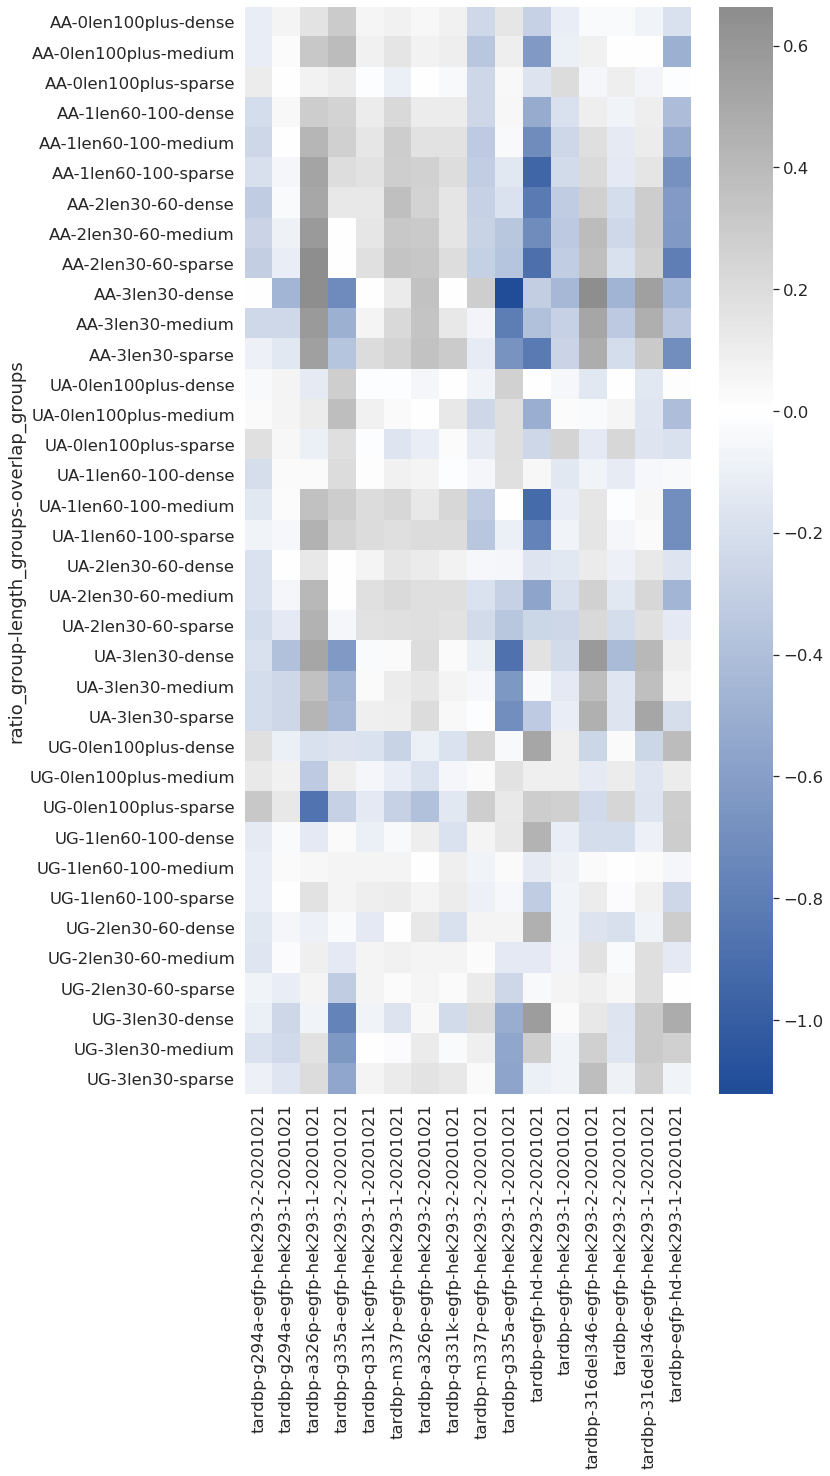

In [59]:
sns.heatmap(df_heatmap1_ex0_norm, yticklabels=True, xticklabels=True, cmap=cmap_test, center=0)
plt.savefig('tardbp_post_review_normalised_sum.pdf')

In [60]:
row_order = pd.read_excel('/home/aram/Dropbox (The Francis Crick)/ucl/aram/martina_tdp43/reanalysis_all_samples/row_order.xlsx')

In [62]:
row_order = row_order.rename(columns={'ratio_group_x': 'ratio_group', 'overlap_group': 'overlap_groups'})

In [63]:
df_heatmap1_ex0_norm = df_heatmap1_ex0_norm.reset_index()

In [65]:
df_heatmap1_ex0_norm_rowordered = pd.merge(row_order, df_heatmap1_ex0_norm, on=['ratio_group', 'length_groups', 'overlap_groups'])

In [66]:
df_heatmap1_ex0_norm_rowordered.columns

Index(['ratio_group', 'length_groups', 'overlap_groups',
       'tardbp-g294a-egfp-hek293-2-20201021',
       'tardbp-g294a-egfp-hek293-1-20201021',
       'tardbp-a326p-egfp-hek293-1-20201021',
       'tardbp-g335a-egfp-hek293-2-20201021',
       'tardbp-q331k-egfp-hek293-1-20201021',
       'tardbp-m337p-egfp-hek293-1-20201021',
       'tardbp-a326p-egfp-hek293-2-20201021',
       'tardbp-q331k-egfp-hek293-2-20201021',
       'tardbp-m337p-egfp-hek293-2-20201021',
       'tardbp-g335a-egfp-hek293-1-20201021',
       'tardbp-egfp-hd-hek293-2-20201021', 'tardbp-egfp-hek293-1-20201021',
       'tardbp-316del346-egfp-hek293-2-20201021',
       'tardbp-egfp-hek293-2-20201021',
       'tardbp-316del346-egfp-hek293-1-20201021',
       'tardbp-egfp-hd-hek293-1-20201021'],
      dtype='object')

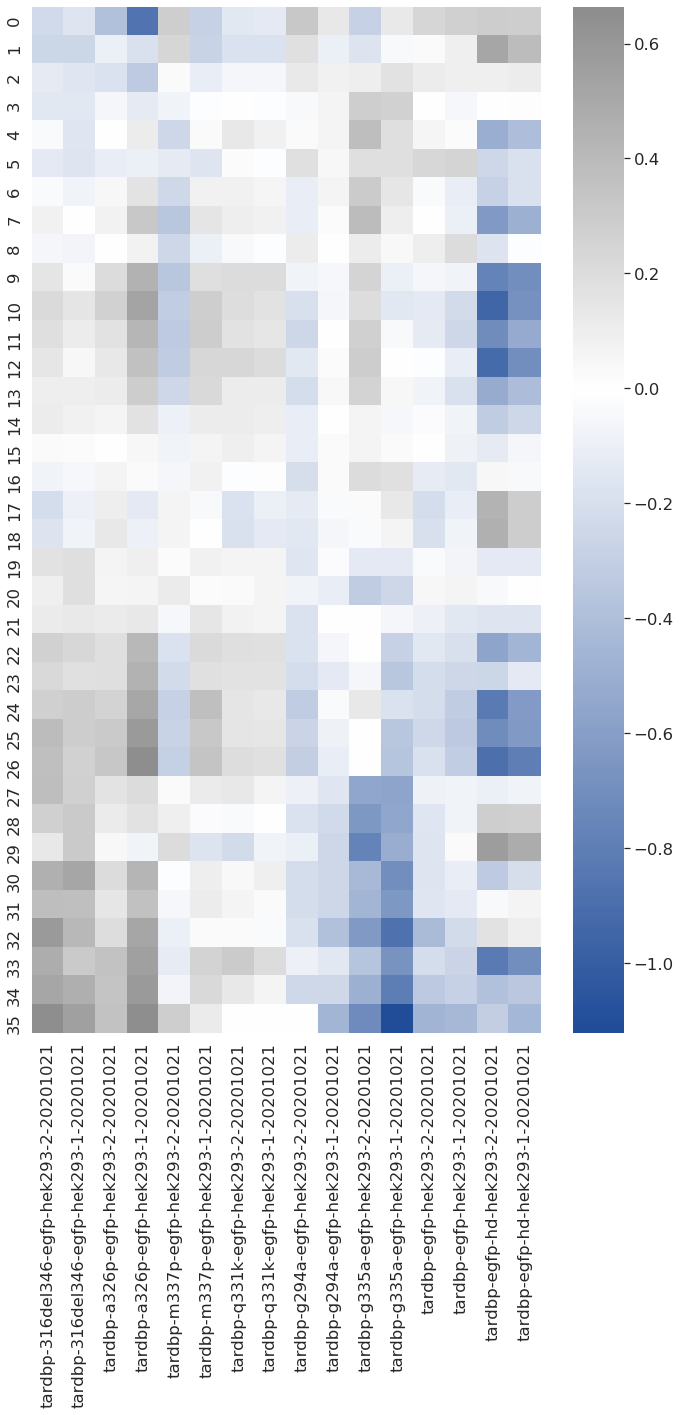

In [70]:
sns.heatmap(df_heatmap1_ex0_norm_rowordered[[
    'tardbp-316del346-egfp-hek293-2-20201021',
    'tardbp-316del346-egfp-hek293-1-20201021',
    'tardbp-a326p-egfp-hek293-2-20201021',
    'tardbp-a326p-egfp-hek293-1-20201021',
    'tardbp-m337p-egfp-hek293-2-20201021',
    'tardbp-m337p-egfp-hek293-1-20201021',
    'tardbp-q331k-egfp-hek293-2-20201021',
    'tardbp-q331k-egfp-hek293-1-20201021',
    'tardbp-g294a-egfp-hek293-2-20201021',
    'tardbp-g294a-egfp-hek293-1-20201021',
    'tardbp-g335a-egfp-hek293-2-20201021',
    'tardbp-g335a-egfp-hek293-1-20201021',
    'tardbp-egfp-hek293-2-20201021',   
    'tardbp-egfp-hek293-1-20201021',
    'tardbp-egfp-hd-hek293-2-20201021',
    'tardbp-egfp-hd-hek293-1-20201021',
       ]], yticklabels=True, xticklabels=True, cmap=cmap_test, center=0)
plt.tight_layout()
plt.savefig('tardbp_post_review_normalised_sum.pdf')